# Sequence to Sequence Machine Translation

In this project we will be traning a neural network to translate from English to French (or theoretically any 2 languages for which we have training data). This is done using a sequence to sequence network, in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence. To improve upon this model we’ll use an attention mechanism, which lets the decoder learn to focus over a specific range of the input sequence.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import os
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler


# Set the device variable for cude if available, else using standard CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # This is for windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # For M1 Mac

The data for this project is a set of many thousands of English to French translation pairs (You can select any other language combination)

There is an open translation site https://tatoeba.org/ which has downloads available at https://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: https://www.manythings.org/anki/. The file is a tab separated list of translation pairs.

In [3]:
# Specify the destination directory (optional)
destination_dir = "data/in/Seq_to_Seq_Machine_Translation"  # Create this directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)  # Create directory if needed

# Import input csv
df = pd.read_csv(destination_dir+'/eng-fra.txt', 
                 sep='\t',
                 header=None)

# Assign custom column names
col_names = ["lang1", "lang2", "license"] # Intentionally keeping it generic so a change in language pairs will not impact the readability of the code
df.columns = col_names

# Select the first two columns (optional)
df = df.iloc[:,:2]
df.head(10)

,lang1,lang2
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !
5,Hi.,Salut.
6,Run!,Cours !
7,Run!,Courez !
8,Run!,Prenez vos jambes à vos cous !
9,Run!,File !


We’ll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count which will be used to replace rare words later.

In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    """
    This class represents a language for building a vocabulary.

    It keeps track of words, their corresponding indices, and their frequencies.
    It also maintains special tokens for Start Of Sequence (SOS) and End Of Sequence (EOS).
    """
        
    def __init__(self, name) -> None:
        """
        Initializes a Lang object with a given name.

        Args:
            name (str): The name of the language.
        """
        self.name = name
        self.word2index = {} # Dictionary mapping words to their unique indices
        self.word2count = {} # Dictionary mapping words to their frequencies
        self.index2word = {0: "SOS", 1: "EOS"} # Dictionary mapping indices to words (including SOS and EOS)
        self.n_words = 2 # Number of words (initialized with SOS and EOS)
    
    
    def addSentence(self, sentence):
        """
        Adds a sentence to the vocabulary by splitting it into words and calling `addWord` for each word.

        Args:
            sentence (str): The sentence to be added.
        """
        for word in sentence.split(' '):
            self.addWord(word)
    

    def addWord(self, word):
        """
        Adds a word to the vocabulary if it hasn't been seen before. 
        If the word exists, increments its frequency count.

        Args:
            word (str): The word to be added.
        """
        if word not in self.word2index:
            self.word2index[word] = self.n_words # Assign a unique index to the new word
            self.word2count[word] = 1 # Initialize the word count to 1 (first occurrence)
            self.index2word[self.n_words] = word # Add the word to the index2word dictionary with a new index
            self.n_words += 1 # Increment the total number of words (including SOS and EOS)
        else:
            self.word2count[word] += 1 # If the word already exists, increment its frequency count

In [5]:
# Helper functions

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    """
    Converts a Unicode string to its plain ASCII representation, removing diacritics (accents, umlauts, etc.).

    Args:
        s (str): The Unicode string to be converted.

    Returns:
        str: The ASCII string with diacritics removed.
    """

    return ''.join(
        c for c in unicodedata.normalize('NFD', s)  # Normalize for compatibility with accent removal
        if unicodedata.category(c) != 'Mn' # Filter out non-spacing marks (accents)
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    """
    Normalizes a string by converting it to lowercase, trimming whitespace, removing non-letter characters,
    and isolating punctuation marks.

    Args:
        s (str): The string to be normalized.

    Returns:
        str: The normalized string.
    """

    s = unicodeToAscii(s.lower().strip()) # Convert to ASCII, lowercase, and trim initial/trailing whitespace
    s = re.sub(r"([.!?])", r" \1", s) # Isolate punctuation marks by surrounding them with spaces
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s) # Replace non-letter characters (except punctuation) with spaces
    
    return s.strip() # Remove any remaining leading/trailing whitespace

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English I added the reverse flag to reverse the pairs.

In [6]:
# This function is useful if you want to read the text file directly instead of importing and converting into dataframe with pandas
def readLangs(lang1, lang2, reverse=False):
    """
    Reads language data from a text file and prepares it for processing.

    Args:
        lang1 (str): The name of the first language.
        lang2 (str): The name of the second language.
        reverse (bool, optional): Whether to reverse the input and output languages. Defaults to False.

    Returns:
        tuple: A tuple containing three elements:
            - input_lang (Lang): A Lang object representing the input language.
            - output_lang (Lang): A Lang object representing the output language.
            - pairs (list): A list of lists, where each inner list contains a pair of normalized strings (one from each language).
    """

    print("Reading lines...")

    # Create the file name
    # Specify the destination directory (optional)
    destination_dir = "data/in/Seq_to_Seq_Machine_Translation"  # Create this directory if it doesn't exist
    os.makedirs(destination_dir, exist_ok=True)  # Create directory if needed

    # Import input csv
    df = pd.read_csv(destination_dir+'/%s-%s.txt' % (lang1, lang2), 
                    sep='\t',
                    header=None)

    # Select the first two columns as they contain the 2 languages
    df = df.iloc[:,:2]

    # Assign custom column names
    df.columns = [lang1, lang2]

    # Select the first two columns (optional)
    df.head(10)

    # Normalize the data for both languages
    for lang in df.columns:
        df.loc[:,lang] = df.loc[:,lang].apply(lambda s: normalizeString(s))

    # Reverse pairs, make Lang instances
    if reverse:
        in_lang = lang2 # Input language becomes lang2 (reversed)
        out_lang = lang1 # Output language remains lang1
    else:
        in_lang = lang1 # Input language is lang1
        out_lang = lang2 # Output language is lang2

    # Create lang instances
    input_lang = Lang(in_lang)
    output_lang = Lang(out_lang)


    # Create a new col for a language pair
    df['pairs'] = list(zip(df[in_lang], df[out_lang]))


    return input_lang, output_lang, df


In [7]:
# Making the dataset shorted and including only those sentences that have less than 8 words
MAX_LENGTH = 10


eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p, reverse):
    # Set i depending on the order of languages
    if reverse==False:
        i=0
    else:
        i=1
    
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[i].startswith(eng_prefixes)


def filterPairs(pairs, reverse):
    return [pair for pair in pairs if filterPair(pair, reverse)]


def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, df_pairs = readLangs(lang1, lang2, reverse)
    
    print("Read %s sentence pairs \n" % len(df_pairs))

    # Randomly select n% of the rows to handle the training time. In real world environment, this is not needed
    df_pairs = df_pairs.sample(frac=0.6, random_state=42)
    pairs = df_pairs['pairs'].values
    
    #pairs = df_pairs['pairs'].tolist()
    pairs = filterPairs(pairs, reverse)
    print("Trimmed to %s sentence pairs \n" % len(pairs))
    
    print("Counting words...\n")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

#input_lang, output_lang, pairs = prepareData('eng', 'fra', False)
#print(random.choice(pairs))


## The Seq2Seq model

A Recurrent Neural Network, or RNN, is a network that operates on a sequence and uses its own output as input for subsequent steps.

A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence. Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages. With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.


## The Encoder

Encoder is a RNN that outputs some value for every word from the input sequence. For every input word, the encoder outputs a vector and a hidden state, and used the hidden state for the next input word.

In [8]:
class EncoderRNN(nn.Module):
    """
    Encoder RNN class for processing sequences using a Gated Recurrent Unit (GRU).

    This class takes a sequence of input tokens, embeds them into vectors, and
    passes them through a single-layer GRU to generate a hidden representation
    of the sequence.

    Args:
        input_size (int): The size of the input vocabulary (number of unique tokens).
        hidden_size (int): The size of the hidden state in the GRU.
        dropout_p (float, optional): The probability of dropping out elements during training for regularization. Defaults to 0.1.
    """
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        """
        Initializes an EncoderRNN instance.

        Args:
            input_size (int): The size of the input vocabulary.
            hidden_size (int): The size of the hidden state in the GRU.
            dropout_p (float, optional): The probability of dropping out elements during training.
        """
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
    
    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

## Decoder with Attention

If only the context vector is passed between the encoder and decoder, that single vector carries the burden of encoding the entire sentence. Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Bahdanau attention, also known as additive attention, is a commonly used attention mechanism in sequence-to-sequence models, particularly in neural machine translation tasks. This attention mechanism employs a learned alignment model to compute attention scores between the encoder and decoder hidden states. It utilizes a feed-forward neural network to calculate alignment scores.

In [9]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))

        # squeeze(2) removes the unnecessary dimension of size 1 (resulting from the single output of the linear layer self.Va).
        # unsqueeze(1) adds a new dimension of size 1 at index 1, transforming the scores from (batch_size, sequence_length, 1) to 
        # (batch_size, 1, sequence_length). This is done because the softmax function typically expects the scores to be in the format (batch_size, 1, num_scores)
        scores = scores.squeeze(2).unsqueeze(1)

        # Apply the softmax function across the second dimension (sequence length) of the scores tensor. This normalizes the scores between 0 and 1, effectively converting them into attention weights, where the sum of weights for each decoder step adds up to 1. The resulting weights indicate how much attention the decoder should pay to each encoder output (key) at each step
        weights = F.softmax(scores, dim=1)
        context = torch.bmm(weights, keys)

        return context, weights


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        # Extracts the batch size from the encoder outputs
        batch_size = encoder_outputs.size(0)
        
        # Create a tensor of shape (batch_size, 1) filled with the start-of-sequence (SOS) token index
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        
        # Initialise the decoder hidden state with the final hidden state of the encoder (encoder_hidden).
        decoder_hidden = encoder_hidden

        # Create an empty list to store the decoder and attention outputs at each step
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            # Call the forward_step function with the current decoder input and hidden state to obtain the decoder output and updated hidden state.
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )

            # Append the decoder output for this step to the decoder_outputs list.
            decoder_outputs.append(decoder_output)

            # Append the attention weights for this step to the attention list
            attentions.append(attn_weights)

            # If a target_tensor is provided (during training with ground truth sequences), this line extracts the target token for the current step (i) 
            # from each sequence in the batch and reshapes it to (batch_size, 1) to serve as the next decoder input. This allows the decoder to "learn" 
            # from the target sequence during training.
            if target_tensor is not None:
                # Feed target as next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            # If no target_tensor is provided (during inference or greedy decoding), this line finds the most probable token (top-1 with highest 
            # probability) from the current decoder output (decoder_output).
            else:
                # Use its own predictions as next input
                _, topi = decoder_output.topk(1)

                # Extract the index of the top token, remove unnecessary dimensions, and detach it from the computational graph (as we're not 
                # backpropagating through it during inference). This essentially uses the decoder's own prediction as the next input, allowing it 
                # to generate a sequence token by token.
                decoder_input = topi.squeeze(-1).detach()

        # Concat decoder outputs
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions



    def forward_step(self, input, hidden, encoder_outputs):
        # Apply dropout to embedded input for regularization.
        embedded =  self.dropout(self.embedding(input))

        # Reshape hidden state for compatibility with attention mechanism
        query = hidden.permute(1, 0, 2)
        
        # Compute attention context and weights using BahdanauAttention.
        context, attn_weights = self.attention(query, encoder_outputs)

        # Concatenate embedded input and context for GRU input
        input_gru = torch.cat((embedded, context), dim=2)

        # Run GRU to update hidden state and generate output.
        output, hidden = self.gru(input_gru, hidden)

        # Apply output layer for final predictions.
        output = self.out(output)

        return output, hidden, attn_weights




## Prepare the Training data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size, pairs):

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    
    return train_dataloader

In [11]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    """
    Trains the encoder and decoder for one epoch.

    Args:
       dataloader (DataLoader): Dataloader providing batches of data
       encoder (torch.nn.Module): Encoder model
       decoder (torch.nn.Module): Decoder model
       encoder_optimizer (torch.optim.Optimizer): Optimizer for the encoder
       decoder_optimizer (torch.optim.Optimizer): Optimizer for the decoder
       criterion (torch.nn.Module): Loss function

    Returns:
       float: Average loss for the epoch
    """
    
    total_loss = 0
    for data in dataloader:
        # Get input and target tensors from the batch
        input_tensor, target_tensor = data

        # Zero gradients for both encoder and decoder
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Run input through the encoder
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Run encoder outputs and hidden state through the decoder
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        # Reshape decoder outputs and target tensor for loss calculation
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)), # Flatten decoder outputs
            target_tensor.view(-1) # Flatten target tensor
        )

        # Backpropagate the loss through both networks
        loss.backward()

         # Update parameters of both encoder and decoder
        encoder_optimizer.step()
        decoder_optimizer.step()

        # Add to total loss (to calc avg loss)
        total_loss += loss.item()

    # Calculate and return average loss for the epoch
    return total_loss / len(dataloader)

In [12]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Ensure plots are generated in non-interactive environments
#plt.switch_backend('agg')

def showPlot(points):
    """Creates a plot of the given points.

    Args:
       points: A list or array of points to be plotted.
    """
    plt.figure()
    fig, ax = plt.subplots()

    # Set regular intervals for y-axis ticks
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)

    # Plot the points
    plt.plot(points)

    
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    """Trains the encoder and decoder models for a specified number of epochs.

    Args:
        train_dataloader: A DataLoader object providing training data.
        encoder: The encoder model to be trained.
        decoder: The decoder model to be trained.
        n_epochs: Number of epochs to train for.
        learning_rate: Learning rate for model optimizers.
        print_every: Print training progress every `print_every` epochs.
        plot_every: Plot the loss curve every `plot_every` epochs.
    """
    start = time.time() # Record starting time
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # Create optimizers for encoder and decoder with learning rate
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    # Loss function for training
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f"Time Elapsed: {timeSince(start, epoch / n_epochs)}; No. of Epochs: {epoch}/{n_epochs}; Avg Loss: {print_loss_avg:.4f}")

        # Plot the loss curve every `plot_every` epochs
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0 

    # Plot losses
    showPlot(plot_losses)

    # Return losses
    return plot_losses

In [14]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    """
    Evaluates the translation capability of the encoder-decoder model on a given sentence.

    Args:
        encoder: The encoder model.
        decoder: The decoder model.
        sentence: The sentence to be translated (string).
        input_lang: The input language object.
        output_lang: The output language object.

    Returns:
        A list of decoded words (string) and decoder attention (optional).
    """
    with torch.no_grad():
        # Disable gradient calculation for evaluation
        input_tensor = tensorFromSentence(input_lang, sentence)

        # Encode the input sentence
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Decode the encoded representation
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        # Get the most likely word at each step
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()  # Remove extra dimensions

        # Build the decoded sentence word by word
        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])

    return decoded_words, decoder_attn


In [15]:
def evaluateRandomly(encoder, decoder, pairs, n=10):
    
    for i in range(n):
        # Select a random text pair
        pair = random.choice(pairs)
        print('Actual Input > ', pair[0])
        print('Actual Translation = ', pair[1])

        
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('Predicted Translation < ', output_sentence)
        print('')
        

## Training and Evaluating

Reading lines...
Read 229803 sentence pairs 

Trimmed to 10764 sentence pairs 

Counting words...

Counted words:
eng 3084
fra 4559
Time Elapsed: 1m 19s (- 19m 56s); No. of Epochs: 5/80; Avg Loss: 1.9520
Time Elapsed: 2m 35s (- 18m 9s); No. of Epochs: 10/80; Avg Loss: 0.8907
Time Elapsed: 3m 51s (- 16m 43s); No. of Epochs: 15/80; Avg Loss: 0.5058
Time Elapsed: 5m 7s (- 15m 22s); No. of Epochs: 20/80; Avg Loss: 0.3344
Time Elapsed: 7m 12s (- 15m 50s); No. of Epochs: 25/80; Avg Loss: 0.2510
Time Elapsed: 8m 28s (- 14m 7s); No. of Epochs: 30/80; Avg Loss: 0.2061
Time Elapsed: 9m 44s (- 12m 31s); No. of Epochs: 35/80; Avg Loss: 0.1794
Time Elapsed: 11m 1s (- 11m 1s); No. of Epochs: 40/80; Avg Loss: 0.1622
Time Elapsed: 12m 17s (- 9m 33s); No. of Epochs: 45/80; Avg Loss: 0.1495
Time Elapsed: 13m 33s (- 8m 7s); No. of Epochs: 50/80; Avg Loss: 0.1420
Time Elapsed: 14m 49s (- 6m 44s); No. of Epochs: 55/80; Avg Loss: 0.1364
Time Elapsed: 16m 8s (- 5m 22s); No. of Epochs: 60/80; Avg Loss: 0.1317

<Figure size 640x480 with 0 Axes>

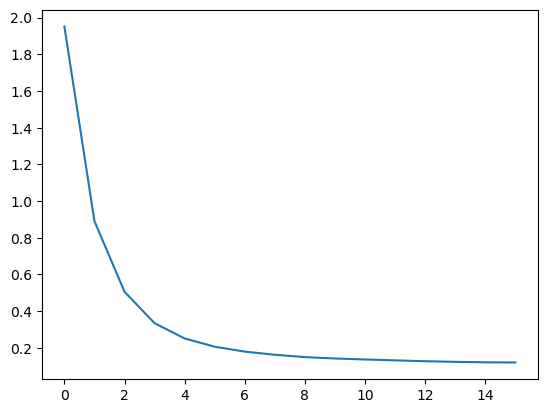

In [17]:
hidden_size = 128
batch_size = 32

# Call the function that reads the languages and creates the vocabulary
input_lang, output_lang, pairs = prepareData('eng', 'fra', reverse=False)

# Create input and output vectors and convert them tensor format (and add EOS token to both sequences)
train_dataloader = get_dataloader(batch_size, pairs)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# Train the model and get the losses over all epochs
losses_over_epochs = train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

## Make predictions

Since the training data used is extremely small, we will just pick a few strings randomly from the dataset. Ideally, these strings should be from an unseen data

In [18]:
# Set encoder and decoder to eval mode for predictions
encoder.eval()
decoder.eval()

# Pick few of the sequences and check for the predictions
evaluateRandomly(encoder, decoder, pairs)

Actual Input >  i m tired of playing games
Actual Translation =  j en ai assez de jouer
Predicted Translation <  je suis fatigue d avoir ete mensonges <EOS>

Actual Input >  i m not happy with my job
Actual Translation =  mon travail ne me plait pas
Predicted Translation <  je ne me satisfais pas mon travail <EOS>

Actual Input >  we re saved
Actual Translation =  nous sommes sauvees
Predicted Translation <  nous sommes tous de pouvoir vous faire ? <EOS>

Actual Input >  i m a french teacher
Actual Translation =  je suis enseignante francaise
Predicted Translation <  je suis desole d etre mal par l une application

Actual Input >  i m retired
Actual Translation =  je suis a la retraite
Predicted Translation <  je suis precisement sur le faire ceci <EOS>

Actual Input >  i m full
Actual Translation =  je suis repu !
Predicted Translation <  je suis desole d etre tombe <EOS>

Actual Input >  you re dangerous
Actual Translation =  tu es dangereux
Predicted Translation <  vous etes plus d 

## Visualising Attention

input = i am going to have dinner
output = je vais vraiment vais a un coup de faire <EOS>


/var/folders/pj/3fn1xxdn4cz7gfp1g7pnb3dm0000gn/T/ipykernel_34015/1508447370.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/pj/3fn1xxdn4cz7gfp1g7pnb3dm0000gn/T/ipykernel_34015/1508447370.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


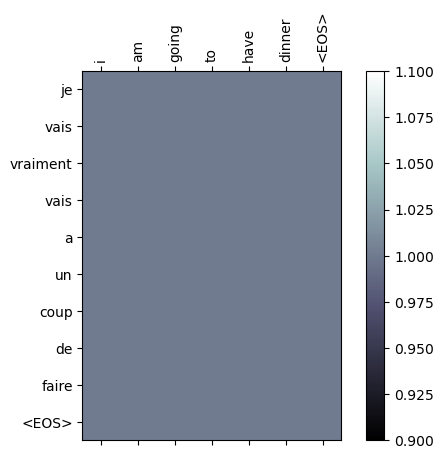


input = you are wrong about the question
output = tu as probablement de le moment <EOS>


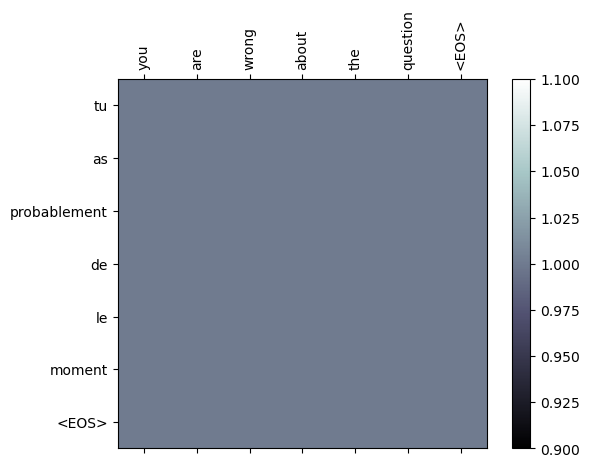

In [19]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))

    # Plot attention for words in the sentence
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])



evaluateAndShowAttention('i am going to have dinner')
print('')
evaluateAndShowAttention('you are wrong about the question')
